In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from joblib import dump, load

pd.set_option('display.max_columns', None)

/home/ian/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
rush_def = pd.read_csv('rush_defense_value_data/rush_def.csv')
rush_def = rush_def.drop(columns = ['Unnamed: 0'])

In [3]:
# Import selected model for testing

model_name = 'logistic_regression'
model_filepath = 'rush_defense_value_saved_models/' + model_name + '.joblib'

clf = load(model_filepath)

/home/ian/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
# Add model predictions to the data frame

from rush_defense_value_helper_functions import get_features, get_label

rush_def_features = get_features(rush_def)
rush_def_win_pred = clf.predict(rush_def_features)
rush_def_win_probs = clf.predict_proba(rush_def_features)[:,1]

rush_def['rush_def_win_pred'] = rush_def_win_pred
rush_def['rush_def_value'] = rush_def_win_probs

rush_def.to_csv('rush_defense_value_data/rush_defense_with_values.csv')

In [5]:
# See descriptive stats for qb value

rush_def.rush_def_value.describe()

count    4596.000000
mean        0.487974
std         0.238816
min         0.016772
25%         0.292790
50%         0.479104
75%         0.674893
max         0.999948
Name: rush_def_value, dtype: float64

In [6]:
# See what factors were most important to qb value

feature_importance = rush_def_features.columns.to_frame().reset_index(drop=True)
feature_importance.columns = ['feature']
feature_importance['mean'] = rush_def_features.mean().to_numpy()
feature_importance['std'] = rush_def_features.std().to_numpy()
feature_importance['importance'] = clf.coef_[0]
feature_importance['importance'] = feature_importance['importance'] * feature_importance['std']
feature_importance['abs_importance'] = abs(feature_importance.importance)
feature_importance_sorted = feature_importance.sort_values(by='abs_importance', ascending=False)
feature_importance_sorted

,feature,mean,std,importance,abs_importance
0,epa_allowed_per_carry,-0.05862,0.214161,-1.266011,1.266011


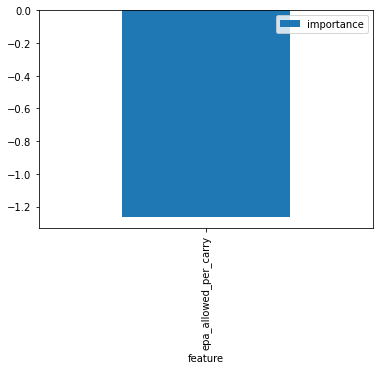

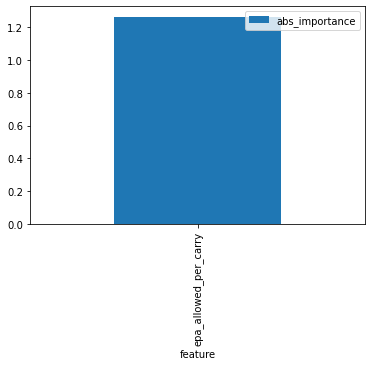

In [7]:
feature_importance_sorted.plot.bar(x='feature', y='importance')

feature_importance_sorted.plot.bar(x='feature', y='abs_importance')

In [8]:
# See where the algorithm went wrong

incorrect = rush_def[rush_def.rush_def_win != rush_def_win_pred]
pred_win_but_loss = len(incorrect[incorrect.rush_def_win_pred==1])
pred_loss_but_win = len(incorrect[incorrect.rush_def_win_pred==0])
total = len(incorrect)

print('Predicted Win, Actual Loss: {}, {}%'.format(pred_win_but_loss, np.round(pred_win_but_loss*100/total, 2)))
print('Predicted Loss, Actual Win: {}, {}%'.format(pred_loss_but_win, np.round(pred_loss_but_win*100/total, 2)))

Predicted Win, Actual Loss: 593, 46.22%
Predicted Loss, Actual Win: 690, 53.78%


In [9]:
incorrect.head(10)

,season,week,team,opponent,score,opponent_score,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,ypc_allowed,epa_allowed_per_carry,rush_td_allowed_per_carry,rush_def_win,rush_def_win_pred,rush_def_value
3,2014,1,BUF,CHI,23,20,18,86.0,-0.055888,0.0,4.777778,-0.003105,0.000000,1,0,0.408553
4,2014,1,CAR,TB,20,14,17,102.0,1.025410,0.0,6.000000,0.060318,0.000000,1,0,0.321939
6,2014,1,CIN,BAL,23,16,21,94.0,-0.093163,1.0,4.476190,-0.004436,0.047619,1,0,0.410456
7,2014,1,CLE,PIT,27,30,29,127.0,-2.260673,2.0,4.379310,-0.077954,0.068966,0,1,0.518122
8,2014,1,DAL,SF,17,28,28,129.0,-3.486463,1.0,4.607143,-0.124517,0.035714,0,1,0.586077
12,2014,1,HOU,WAS,17,6,23,131.0,-3.288876,1.0,5.695652,-0.142995,0.043478,0,1,0.612304
13,2014,1,IND,DEN,24,31,28,105.0,0.667838,1.0,3.750000,0.023851,0.035714,1,0,0.370679
15,2014,1,KC,TEN,10,26,36,165.0,-3.090178,0.0,4.583333,-0.085838,0.000000,0,1,0.529746
17,2014,1,LAC,ARI,17,18,26,110.0,-7.697317,0.0,4.230769,-0.296051,0.000000,0,1,0.796051
19,2014,1,MIA,NE,33,20,20,89.0,3.505328,1.0,4.450000,0.175266,0.050000,1,0,0.193974


In [10]:
# Look at some of the best rush defenses by rush  value

rush_def_avg_value = rush_def.groupby(by='team').rush_def_value.agg(['mean', 'min', 'max', 'count'])
rush_def_avg_value.sort_values(by='mean', ascending=False)

,mean,min,max,count
team,,,,
BAL,0.553249,0.088190,0.948652,144
SEA,0.540990,0.060268,0.985523,149
NYJ,0.530336,0.024142,0.964810,138
LA,0.518873,0.090680,0.996294,148
DEN,0.518583,0.041483,0.984238,142
NO,0.518445,0.027538,0.999948,146
ARI,0.518290,0.044920,0.990798,141
TB,0.514315,0.037887,0.995312,145
PIT,0.505934,0.038354,0.987789,145


In [11]:
incorrect.sort_values(by='rush_def_value', ascending=False).head(20)

,season,week,team,opponent,score,opponent_score,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,ypc_allowed,epa_allowed_per_carry,rush_td_allowed_per_carry,rush_def_win,rush_def_win_pred,rush_def_value
1110,2016,2,HOU,KC,19,12,19,119.0,-14.281271,0.0,6.263158,-0.751646,0.000000,0,1,0.982961
301,2014,11,GB,PHI,53,20,31,109.0,-20.012804,0.0,3.516129,-0.645574,0.000000,0,1,0.968568
1783,2017,7,CHI,CAR,17,3,30,108.0,-17.080074,0.0,3.600000,-0.569336,0.000000,0,1,0.951539
3528,2020,12,LA,SF,20,23,33,112.0,-17.209580,1.0,3.393939,-0.521502,0.030303,0,1,0.936704
2090,2017,17,JAX,TEN,10,15,38,117.0,-19.525873,0.0,3.078947,-0.513839,0.000000,0,1,0.933965
2838,2019,6,SF,LA,20,7,22,109.0,-11.098882,1.0,4.954545,-0.504495,0.045455,0,1,0.930475
2744,2019,3,NO,SEA,33,27,26,108.0,-12.231517,2.0,4.153846,-0.470443,0.076923,0,1,0.916270
3118,2019,16,HOU,TB,23,20,21,106.0,-9.386206,1.0,5.047619,-0.446962,0.047619,0,1,0.904987
3430,2020,9,BAL,IND,24,10,21,112.0,-9.344688,1.0,5.333333,-0.444985,0.047619,0,1,0.903977
427,2014,15,IND,HOU,17,10,41,137.0,-18.189377,0.0,3.341463,-0.443643,0.000000,0,1,0.903287


In [12]:
# Look at some of the best def by rush_def value, season by season

rush_def_avg_value = rush_def.groupby(by=['team', 'season']).rush_def_value.agg(['mean', 'min', 'max', 'count'])
rush_def_avg_value[150:200]

mean       min       max  count
team season                                     
LA   2020    0.536817  0.127232  0.943705     18
     2021    0.496929  0.126952  0.979905     21
     2022    0.532030  0.285923  0.873339      9
LAC  2014    0.538457  0.063472  0.904927     16
     2015    0.422385  0.092869  0.756410     16
     2016    0.498030  0.110363  0.870290     16
     2017    0.428066  0.098873  0.807813     16
     2018    0.465051  0.193926  0.909696     18
     2019    0.473750  0.025547  0.908457     16
     2020    0.490369  0.104714  0.861729     16
     2021    0.380261  0.083031  0.950069     17
     2022    0.321858  0.072440  0.505679      9
LV   2014    0.533536  0.225719  0.942958     16
     2015    0.520560  0.063131  0.953290     16
     2016    0.518740  0.037604  0.902544     17
     2017    0.495770  0.181956  0.849549     16
     2018    0.355894  0.077626  0.740818     16
     2019    0.520579  0.080835  0.919170     16
     2020    0.376509  0.064551  0.726077     16
     2021    0.545476  0.198399  0.925776     18
     2022    0.452563  0.075474  0.882914      9
MIA  2014    0.498690  0.091381  0.982249     16
     2015    0.510271  0.052767  0.824883     16
     2016    0.399949  0.095464  0.826666     17
     2017    0.558946  0.062012  0.864197     16
     2018    0.427872  0.024268  0.870420     16
     2019    0.444498  0.105372  0.799066     16
     2020    0.415117  0.087240  0.771579     16
     2021    0.433404  0.065659  0.702743     17
     2022    0.423053  0.095773  0.845653     10
MIN  2014    0.436743  0.142791  0.745173     16
     2015    0.542121  0.082930  0.969865     17
     2016    0.548503  0.310823  0.990489     16
     2017    0.609731  0.142958  0.948396     18
     2018    0.563712  0.169177  0.939235     15
     2019    0.543409  0.102348  0.943795     18
     2020    0.385137  0.054035  0.906185     16
     2021    0.378102  0.135690  0.832507     17
     2022    0.485975  0.223385  0.753873      9
NE   2014    0.531963  0.119185  0.872821     19
     2015    0.580338  0.123610  0.932489     18
     2016    0.540999  0.046071  0.946766     19
     2017    0.409999  0.083318  0.832928     19
     2018    0.478509  0.024963  0.979271     19
     2019    0.568615  0.336020  0.964163     17
     2020    0.357851  0.071076  0.714064     16
     2021    0.433489  0.016772  0.915127     18
     2022    0.529659  0.038066  0.891390      9
NO   2014    0.387652  0.131371  0.856340     16
     2015    0.519544  0.223515  0.871847     16

In [17]:
# Look at games for current season

rush_def[(rush_def.season == 2022) & (rush_def.team == 'IND')]

,season,week,team,opponent,score,opponent_score,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,ypc_allowed,epa_allowed_per_carry,rush_td_allowed_per_carry,rush_def_win,rush_def_win_pred,rush_def_value
4339,2022,2,IND,JAX,0,24,36,97.0,-10.236191,1.0,2.694444,-0.284339,0.027778,1,1,0.784580
4371,2022,3,IND,KC,20,17,23,58.0,-2.043155,1.0,2.521739,-0.088833,0.043478,1,1,0.534154
4403,2022,4,IND,TEN,17,24,25,130.0,2.330814,1.0,5.200000,0.093233,0.040000,0,0,0.281012
4435,2022,5,IND,DEN,12,9,26,127.0,-1.542432,0.0,4.884615,-0.059324,0.000000,0,0,0.490598
4465,2022,6,IND,JAX,34,27,32,244.0,11.344586,3.0,7.625000,0.354518,0.093750,0,0,0.076985
4494,2022,7,IND,TEN,10,19,33,140.0,-9.992868,0.0,4.242424,-0.302814,0.000000,0,1,0.802466
4523,2022,8,IND,WAS,16,17,28,96.0,-5.706785,1.0,3.428571,-0.203814,0.035714,1,1,0.693501
4550,2022,9,IND,NE,3,26,27,72.0,-6.819194,0.0,2.666667,-0.252563,0.000000,1,1,0.751143
4577,2022,10,IND,LV,25,20,24,77.0,-6.299166,1.0,3.208333,-0.262465,0.041667,1,1,0.761924


In [14]:
rush_def[rush_def.season == 2022].groupby(by='team').mean()['rush_def_value'].sort_values(ascending=False)

team
IND    0.575151
LA     0.532030
NE     0.529659
TEN    0.523461
WAS    0.517985
JAX    0.515527
SEA    0.507470
SF     0.504689
CAR    0.503957
TB     0.499737
MIN    0.485975
NO     0.475624
BUF    0.457777
LV     0.452563
KC     0.451008
DEN    0.447593
PIT    0.442251
ARI    0.437956
NYJ    0.431639
MIA    0.423053
DAL    0.422302
BAL    0.421177
CHI    0.410544
CIN    0.404640
ATL    0.400846
NYG    0.398088
GB     0.380589
PHI    0.336237
LAC    0.321858
HOU    0.316719
DET    0.274924
CLE    0.221011
Name: rush_def_value, dtype: float64

In [15]:
rush_def[(rush_def.season == 2022) & (rush_def.week == 10)]

,season,week,team,opponent,score,opponent_score,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,ypc_allowed,epa_allowed_per_carry,rush_td_allowed_per_carry,rush_def_win,rush_def_win_pred,rush_def_value
4566,2022,10,ARI,LA,27,17,19,67.0,1.325160,1.0,3.526316,0.069745,0.052632,1,0,0.309896
4567,2022,10,ATL,CAR,15,25,47,232.0,6.690620,2.0,4.936170,0.142354,0.042553,0,0,0.226212
4568,2022,10,BUF,MIN,30,33,24,148.0,0.556890,2.0,6.166667,0.023204,0.083333,0,0,0.371573
4569,2022,10,CAR,ATL,25,15,25,138.0,1.148307,0.0,5.520000,0.045932,0.000000,0,0,0.340777
4570,2022,10,CHI,DET,30,31,30,96.0,-7.023046,2.0,3.200000,-0.234102,0.066667,1,1,0.730189
4571,2022,10,CLE,MIA,17,39,30,195.0,7.854147,2.0,6.500000,0.261805,0.066667,0,0,0.126092
4572,2022,10,DAL,GB,28,31,38,210.0,7.046053,1.0,5.526316,0.185422,0.026316,0,0,0.184759
4573,2022,10,DEN,TEN,10,17,23,63.0,-9.867366,0.0,2.739130,-0.429016,0.000000,1,1,0.895465
4574,2022,10,DET,CHI,31,30,35,258.0,8.061133,2.0,7.371429,0.230318,0.057143,0,0,0.148069
4575,2022,10,GB,DAL,31,28,31,159.0,7.290192,1.0,5.129032,0.235167,0.032258,0,0,0.144489
